<a href="https://colab.research.google.com/github/JustineDataEng/Air-Quality-PM2.5-Forecasting-A-Comparative-Case-Study/blob/main/Air_Quality_Data_ARIMA_Reg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This cell imports all the necessary Python libraries for data manipulation (`pandas`, `numpy`), visualization (`matplotlib.pyplot`, `plotly.express`, `seaborn`), time series analysis (`statsmodels.tsa.arima`, `statsmodels.graphics.tsaplots`), and model evaluation (`sklearn.metrics`). It also imports `glob` for file handling, `time` for performance measurement, `datetime` for date/time operations, and `pprint` for pretty printing, along with `warnings` to suppress non-critical messages.

In [ ]:
from glob import glob
import time
from datetime import datetime
from pprint import PrettyPrinter
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import plotly.express as px
import seaborn as sns
from sklearn.metrics import mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings("ignore")

The `wrangle` function is defined to clean and preprocess the raw sensor data. It performs the following steps:
- Reads a CSV file into a pandas DataFrame.
- Filters for `value_type` 'P2' (PM2.5 readings).
- Drops irrelevant columns such as `sensor_id`, `sensor_type`, `location`, `lat`, and `lon`.
- Renames the `value` column to `P2`.
- Drops the `value_type` column.
- Converts the `timestamp` column to datetime objects.
- Sets the `timestamp` column as the DataFrame index and converts the timezone to 'Africa/Dar_es_Salaam'.
- Resamples the data to an hourly frequency, taking the mean of `P2` values, and then forward-fills any missing values, ensuring a continuous hourly time series.

In [ ]:
def wrangle(collection):
  df = pd.read_csv(collection, sep=';')
  df = df[df["value_type"] == "P2"]
  df.drop(columns=["sensor_id",	"sensor_type",	"location",	"lat",	"lon"], inplace=True)
  df = df.rename(columns={'value': 'P2'})
  df.drop(columns=["value_type"], inplace=True)
  df['timestamp'] = pd.to_datetime(df['timestamp']) # Convert to datetime
  df = pd.DataFrame(df).set_index("timestamp")
  df.index = df.index.tz_convert("Africa/Dar_es_Salaam") # Directly convert timezone
  df = df["P2"].resample("1H").mean().fillna(method="ffill").to_frame()

  return df

This cell uses the `glob` function from the `glob` module to find all files ending with `.csv` in the current directory. The output lists the names of the CSV files, which represent different months of sensor data archives.

In [ ]:
files = glob("*.csv")
files

['january_2018_sensor_data_archive.csv',
 'march_2018_sensor_data_archive.csv',
 'november_2017_sensor_data_archive.csv',
 'february_2018_sensor_data_archive.csv',
 'december_2017_sensor_data_archive.csv',
 'october_2017_sensor_data_archive.csv']

This cell processes all the identified CSV files. It applies the `wrangle` function to each file, creating a list of cleaned pandas DataFrames. These DataFrames are then concatenated into a single DataFrame `df`, and sorted by their time-based index. The output shows the first and last few rows of the combined DataFrame, demonstrating that the data has been loaded, cleaned, and organized by timestamp.

In [ ]:
frames = [wrangle(file) for file in files]
df = pd.concat(frames)
df.sort_index(inplace=True)
df

,P2
timestamp,
2017-10-08 13:00:00+03:00,9.246000
2017-10-08 14:00:00+03:00,13.831111
2017-10-08 15:00:00+03:00,10.700000
2017-10-08 16:00:00+03:00,10.700000
2017-10-08 17:00:00+03:00,10.700000
...,...
2018-03-31 22:00:00+03:00,9.547083
2018-03-31 23:00:00+03:00,6.301765
2018-04-01 00:00:00+03:00,7.293125


This cell uses the `.describe()` method to generate descriptive statistics for the `P2` column in the DataFrame. This provides a quick summary of the central tendency, dispersion, and shape of the distribution of PM2.5 readings, including count, mean, standard deviation, min, max, and quartile values. These statistics help in understanding the range and typical values of the sensor data.

In [ ]:
df.describe()

,P2
count,4190.000000
mean,8.194663
std,5.365058
min,0.754028
25%,4.254627
50%,7.177969
75%,10.700000
max,57.019787


This cell generates a box plot of the `P2` (PM2.5) readings. A box plot visually displays the distribution of numerical data and skewness by showing quartiles (the median, lower, and upper quartiles), and potential outliers. The plot helps in understanding the spread, central tendency, and presence of extreme values in the PM2.5 sensor data.

<Axes: title={'center': 'Distribution of PM2.5 Readings'}>

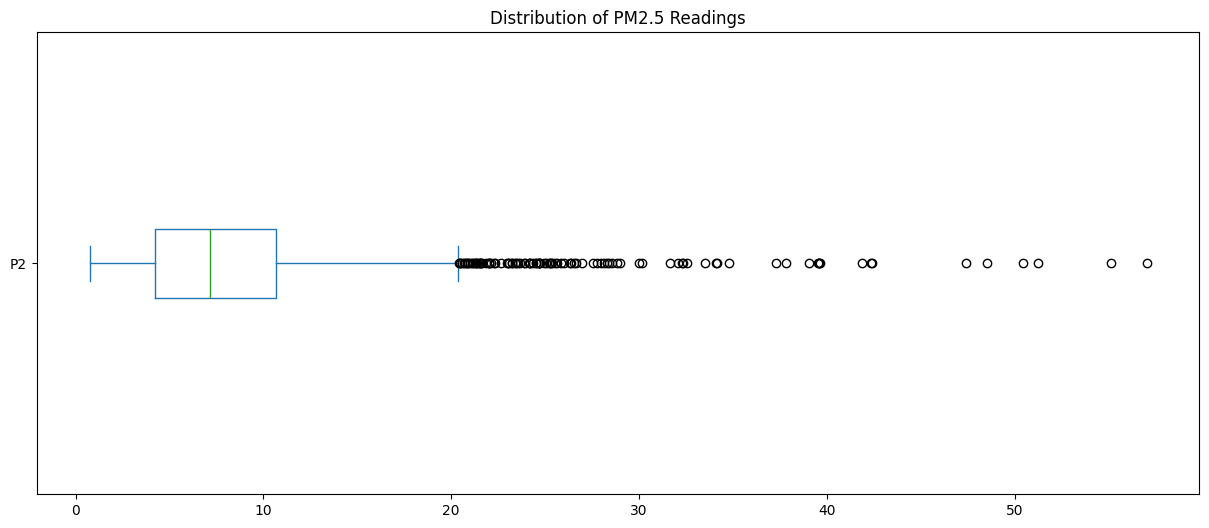

In [ ]:
fig, ax = plt.subplots(figsize=(15, 6))

df["P2"].plot(kind="box", vert=False, title="Distribution of PM2.5 Readings", ax=ax)

This cell generates an Autocorrelation Function (ACF) plot for the `P2` time series data. The ACF plot shows the correlation of the series with its own lagged values. It helps in identifying the order of a Moving Average (MA) component in an ARIMA model and detecting seasonality. The x-axis represents the lag in hours, and the y-axis represents the correlation coefficient. The plot reveals strong correlations at various lags, suggesting underlying patterns and dependencies in the data.

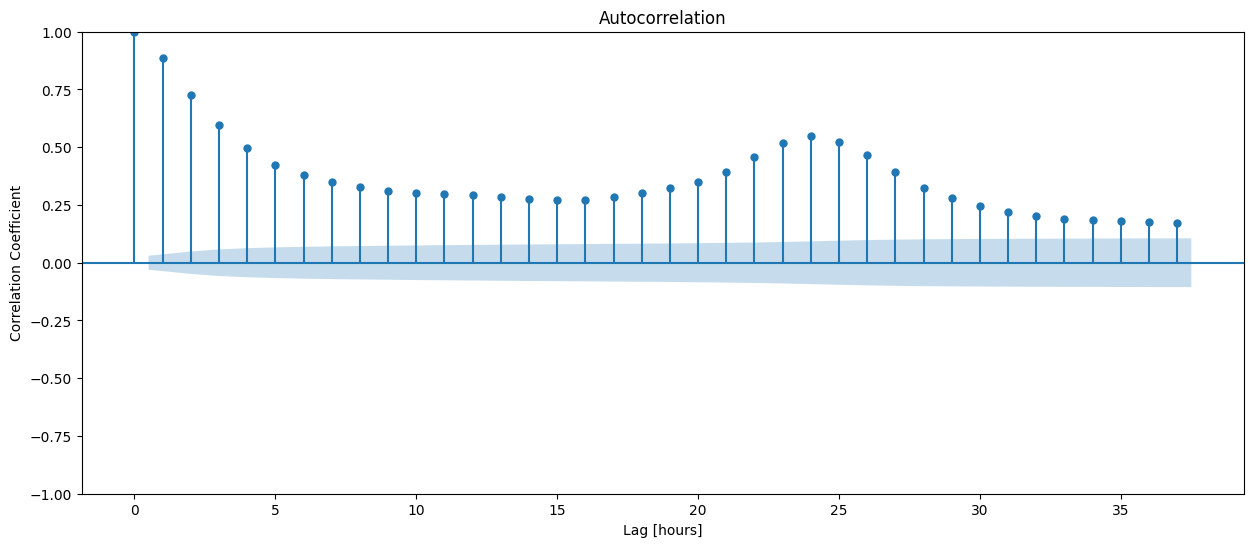

In [ ]:
fig, ax = plt.subplots(figsize=(15, 6))
plot_acf(df, ax=ax)
plt.xlabel("Lag [hours]")
plt.ylabel("Correlation Coefficient");

This cell generates a Partial Autocorrelation Function (PACF) plot for the `P2` time series data. The PACF plot shows the direct correlation of the series with its own lagged values, after removing the influence of intermediate lags. It helps in identifying the order of an Autoregressive (AR) component in an ARIMA model. The x-axis represents the lag in hours, and the y-axis represents the correlation coefficient. The plot helps in determining the appropriate `p` parameter for the ARIMA model.

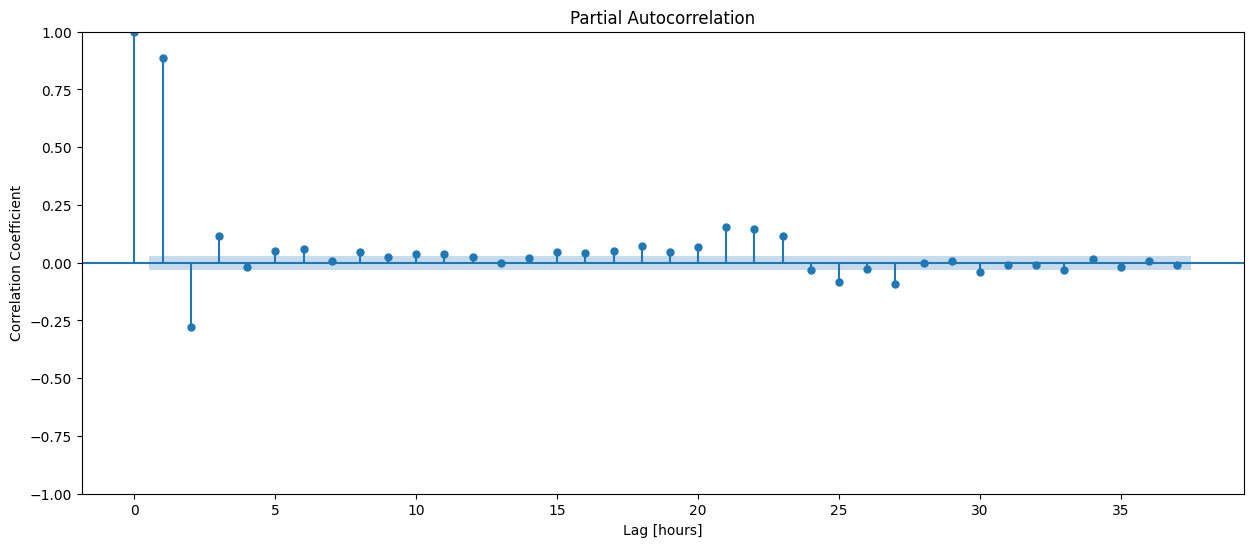

In [ ]:
fig, ax = plt.subplots(figsize=(15, 6))
plot_pacf(df, ax=ax)
plt.xlabel("Lag [hours]")
plt.ylabel("Correlation Coefficient");

In [ ]:
int(len(df))

4190

This cell splits the dataset `df` into training (`y_train`) and testing (`y_test`) sets. The training data includes all observations up to the end of December 2017, while the test data consists of observations from January 2018. The output shows the shapes of `y_train` and `y_test`, indicating the number of observations in each set, which is crucial for evaluating the model's performance on unseen data.

In [ ]:
y_train = df.loc[:"2017-12"]
y_test = df.loc["2018-01":"2018-01"]
y_train.shape, y_test.shape

((2027, 1), (744, 1))

This cell calculates a baseline Mean Absolute Error (MAE) for the training data. It does this by predicting the mean of `y_train` for all observations in the training set. This baseline provides a simple reference point against which more complex time series models can be compared. The output shows the mean P2 reading and the calculated baseline MAE, indicating the typical error if we were to always predict the average value.

In [ ]:
y_train_mean = y_train.mean()
y_pred_baseline = [y_train_mean] * len(y_train)
mae_baseline = mean_absolute_error(y_train, y_pred_baseline)

print("Mean P2 Reading:", round(y_train_mean, 2))
print("Baseline MAE:", round(mae_baseline, 2))

Mean P2 Reading: P2    7.54
dtype: float64
Baseline MAE: 3.56


This cell defines the ranges for the `p` (autoregressive) and `q` (moving average) parameters that will be explored during the ARIMA model grid search. `p_params` specifies that `p` will take values 0, 8, 16, and 24, while `q_params` specifies that `q` will take values 0, 1, and 2. These ranges are chosen to systematically search for optimal model orders.

In [ ]:
p_params = range(0, 25, 8)
q_params = range(0, 3, 1)

This cell performs a grid search to find the optimal `p` and `q` parameters for an ARIMA(p, 0, q) model (where the differencing term `d` is 0). It iterates through all combinations of `p` and `q` defined in `p_params` and `q_params`. For each combination:
- An ARIMA model is trained on `y_train`.
- The training time is measured and printed.
- In-sample predictions are generated.
- The Mean Absolute Error (MAE) is calculated for the training predictions.
- The calculated MAE is stored in the `mae_grid` dictionary. The output shows the training time for each `(p, 0, q)` order and finally prints the complete `mae_grid` dictionary, which contains the MAE for each parameter combination.

In [ ]:
# Create dictionary to store MAEs
mae_grid = dict()
# Outer loop: Iterate through possible values for `p`
for p in p_params:
    # Create key-value pair in dict. Key is `p`, value is empty list.
    mae_grid[p] = list()
    # Inner loop: Iterate through possible values for `q`
    for q in q_params:
        # Combination of hyperparameters for model
        order = (p, 0, q)
        # Note start time
        start_time = time.time()
        # Train model
        model = ARIMA(y_train, order=order).fit()
        # Calculate model training time
        elapsed_time = round(time.time() - start_time, 2)
        print(f"Trained ARIMA {order} in {elapsed_time} seconds.")
        # Generate in-sample (training) predictions
        y_pred = model.predict()
        # Calculate training MAE
        mae = mean_absolute_error(y_train, y_pred)
        # Append MAE to list in dictionary
        mae_grid[p].append(mae)

print()
print(mae_grid)

Trained ARIMA (0, 0, 0) in 0.27 seconds.
Trained ARIMA (0, 0, 1) in 0.23 seconds.
Trained ARIMA (0, 0, 2) in 0.36 seconds.
Trained ARIMA (8, 0, 0) in 0.8 seconds.
Trained ARIMA (8, 0, 1) in 5.56 seconds.
Trained ARIMA (8, 0, 2) in 5.81 seconds.
Trained ARIMA (16, 0, 0) in 5.06 seconds.
Trained ARIMA (16, 0, 1) in 12.88 seconds.
Trained ARIMA (16, 0, 2) in 13.77 seconds.
Trained ARIMA (24, 0, 0) in 16.9 seconds.
Trained ARIMA (24, 0, 1) in 32.51 seconds.
Trained ARIMA (24, 0, 2) in 33.46 seconds.

{0: [3.5578346818961224, 2.1640992968597312, 1.6738760902301801], 8: [1.1397550991373362, 1.1249315561781124, 1.0800477862648457], 16: [1.131911774825552, 1.1307681511515888, 1.1305386682557101], 24: [1.0981514773072991, 1.0978084668422794, 1.0963727221292712]}


This cell simply displays the `mae_grid` dictionary that was populated in the previous step. This dictionary contains the Mean Absolute Error (MAE) values for each combination of `p` and `q` parameters explored during the ARIMA grid search. It provides a direct view of the model performance for different hyperparameter settings.

In [ ]:
mae_grid

{0: [3.5578346818961224, 2.1640992968597312, 1.6738760902301801],
 8: [1.1397550991373362, 1.1249315561781124, 1.0800477862648457],
 16: [1.131911774825552, 1.1307681511515888, 1.1305386682557101],
 24: [1.0981514773072991, 1.0978084668422794, 1.0963727221292712]}

This cell converts the `mae_grid` dictionary into a pandas DataFrame named `mae_df`. This transformation makes the results of the grid search easier to visualize and analyze, as it organizes the MAE values into a tabular format where columns represent `p` values and rows represent `q` values. The `round(4)` method is then applied to format the MAE values to four decimal places for better readability.

In [ ]:
mae_df = pd.DataFrame(mae_grid)
mae_df.round(4)

,0,8,16,24
0,3.5578,1.1398,1.1319,1.0982
1,2.1641,1.1249,1.1308,1.0978
2,1.6739,1.0800,1.1305,1.0964


This cell generates a heatmap of the `mae_df` DataFrame. The heatmap uses a 'Blues' colormap, where darker shades indicate lower MAE values. The x-axis represents the `p` values, and the y-axis represents the `q` values. The title indicates that this is an 'ARMA Grid Search (Criteria: MAE)'. This visualization allows for quick identification of the `(p, q)` combination that yielded the lowest Mean Absolute Error, which helps in selecting the best-performing ARIMA model hyperparameters.

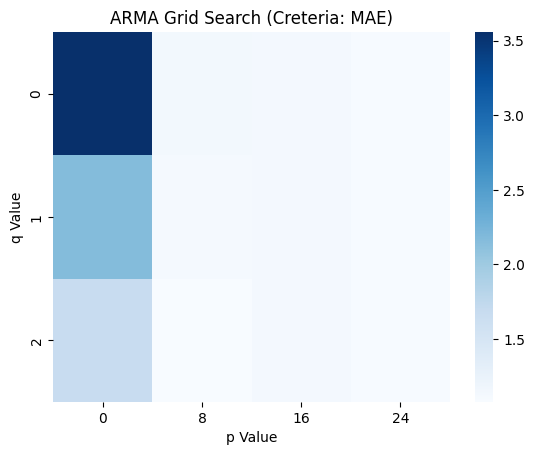

In [ ]:
sns.heatmap(mae_df, cmap="Blues")
plt.xlabel("p Value")
plt.ylabel("q Value")
plt.title("ARMA Grid Search (Creteria: MAE)");

This cell generates diagnostic plots for the last trained ARIMA model (which was ARIMA(24,0,2) from the grid search). The `plot_diagnostics` function typically produces four plots:
1.  **Standardized Residuals:** Shows whether the residuals are randomly scattered around zero.
2.  **Histogram plus KDE:** Visualizes the distribution of residuals, ideally close to a normal distribution.
3.  **Normal Q-Q plot:** Compares the distribution of residuals to a normal distribution.
4.  **Correlogram (ACF of residuals):** Checks for any remaining autocorrelation in the residuals, which should ideally be minimal.These plots are essential for assessing if the model assumptions are met and if the model adequately captures the patterns in the data.

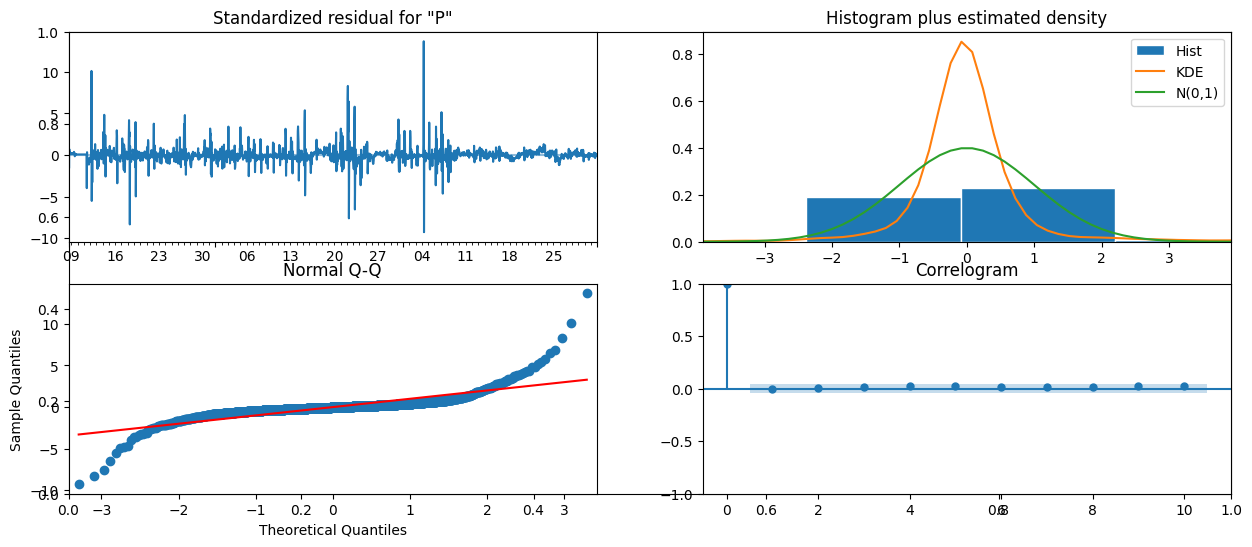

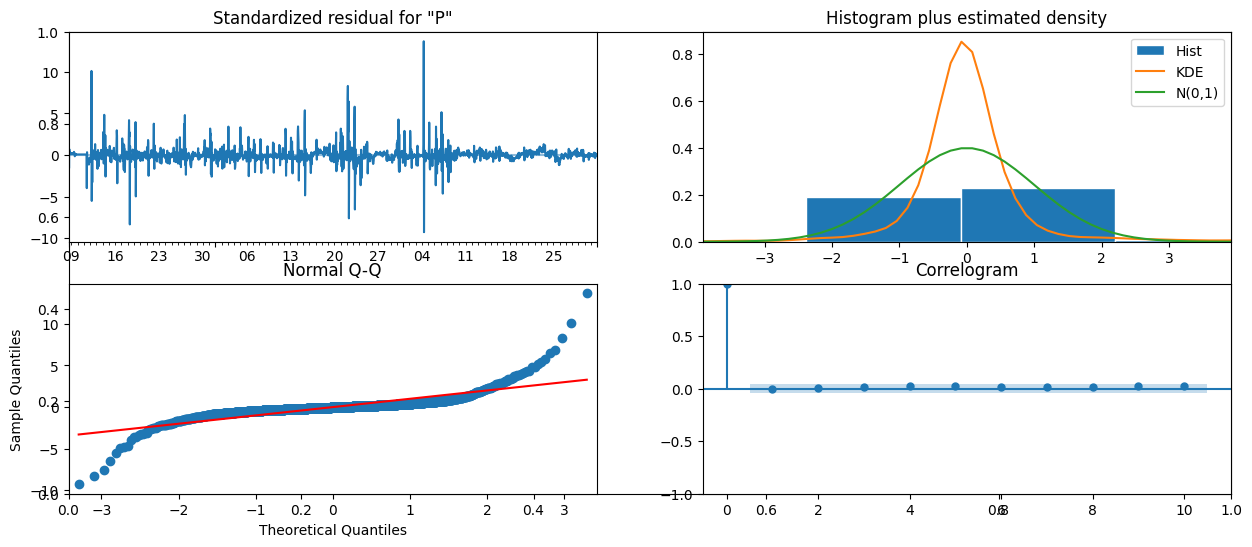

In [ ]:
fig, ax = plt.subplots(figsize=(15, 6))
model.plot_diagnostics(fig=fig)

This cell performs a **walk-forward validation** on the test set (`y_test`) using the best-performing ARIMA order identified from the grid search, which is `(8, 0, 2)`. In walk-forward validation:
- The model is initialized with the training data (`history`).
- In each iteration, the model is retrained on the `history` data.
- A one-step forecast (`next_pred`) is made for the next unseen data point.
- This forecast is appended to `y_pred_wfv`.
- The actual value from the test set corresponding to the forecasted timestamp is added to the `history` for the next iteration.
This process simulates a real-world forecasting scenario where the model continuously learns from new observations. The cell prints the progress of this iterative training and forecasting.

In [ ]:
y_pred_wfv = pd.Series()
history = y_train.copy()
for i in range(len(y_test)):
    model = ARIMA(history, order=(8, 0, 2)).fit()
    next_pred = model.forecast()
    y_pred_wfv = pd.concat([y_pred_wfv, next_pred])
    history = pd.concat([history, y_test.loc[next_pred.index]])

This cell calculates the Mean Absolute Error (MAE) between the actual values in `y_test` and the predictions generated by the walk-forward validation (`y_pred_wfv`). The MAE provides a measure of the average magnitude of the errors in a set of predictions, without considering their direction. A lower MAE indicates better model accuracy. The output shows the test MAE, rounded to two decimal places.

In [ ]:
test_mae = mean_absolute_error(y_test, y_pred_wfv)
print("Test MAE (walk forward validation):", round(test_mae, 2))

Test MAE (walk forward validation): 0.85


This cell calculates the ratio of the test MAE (obtained from walk-forward validation) to the mean of the training data (`y_train_mean`). This ratio provides a normalized measure of the model's error, indicating how large the error is relative to the typical scale of the `P2` values. A smaller ratio suggests that the model's error is a smaller proportion of the average value.

In [ ]:
0.85 / 7.54

0.11273209549071618

This cell formalizes the selection of the best ARIMA model based on the grid search, specifying `best_order = (8, 0, 2)`. It then retrains this optimal model (`model_best`) on the `y_train` data and generates in-sample predictions (`y_pred_train`). Finally, it calculates and prints the Mean Absolute Error (MAE) for these training predictions, confirming the performance of the chosen model on the data it was trained on.

In [ ]:
best_order = (8, 0, 2)
model_best = ARIMA(y_train, order=best_order).fit()
y_pred_train = model_best.predict()
mae_train_best = mean_absolute_error(y_train, y_pred_train)

print(f"Training MAE for ARIMA {best_order}: {mae_train_best:.2f}")

Training MAE for ARIMA (8, 0, 2): 1.08


This cell calculates the ratio of the training MAE of the best model to the mean of the training data. Similar to the test MAE ratio, this provides a normalized metric to understand how well the model fits the training data relative to the average value of the target variable.

In [ ]:
1.08 / 7.54

0.14323607427055704

This cell calculates the R-squared (`r2_score`) for both the walk-forward validation predictions on the test set and the in-sample predictions on the training set. R-squared is a statistical measure that represents the proportion of the variance in the dependent variable that can be explained by the independent variables in a regression model. A higher R-squared value (closer to 1) indicates a better fit. The output shows both R-squared scores, rounded to four decimal places, providing insights into how well the model explains the variability in the PM2.5 readings for both seen and unseen data.

In [ ]:
from sklearn.metrics import r2_score

r2_test = r2_score(y_test['P2'], y_pred_wfv)
print(f"R-squared score for walk-forward test data: {r2_test:.4f}")

r2_train = r2_score(y_train['P2'], y_pred_train)
print(f"R-squared score for training data: {r2_train:.4f}")

R-squared score for walk-forward test data: 0.7959
R-squared score for training data: 0.7965


This cell creates a new DataFrame, `df_predictions`, which combines the actual `y_test` values and the `y_pred_wfv` (walk-forward validation predictions). It then uses `plotly.express` to generate an interactive line plot. This visualization allows for a direct comparison of the model's predictions against the actual PM2.5 readings over the test period, making it easy to observe the model's performance and accuracy.

In [ ]:
df_predictions = pd.DataFrame(
    {"y_test": y_test.squeeze(), "y_pred_wfv": y_pred_wfv}
)

fig = px.line(df_predictions, labels={"value":"PM2.5"})
fig.show()